In [4]:
pkg load image

In [5]:
function padded = padding(matrix, type_of, mask_size)

    % Como usar esta funcion
    % matrix es el valor de la imagen (si es a color, debera ser convertida a escala de grises o binarizarse)
    % type_of es el tipo de padding, 1 es el padding con reflejo, 2 es el padding con zeros (recomendado
    % para morfologia)
    % mask_size  es el TAMANO de la mascara, no la mascara, por que si se desea pasar la mascara, se debe usar
    % size(<mascara>) , nunca pasar la mascara.
    
    [x,y] = size(matrix);
    m_x = mask_size(1);
    m_y = mask_size(2);
    
    if m_x == m_y
        n_ref = (m_x - 1) / 2;
        
        % Mirrored
        if type_of == 1
            temp = matrix;
            
            % left - right
            temp = [fliplr(matrix(:,1:n_ref)) , matrix, fliplr(matrix)(:,1:n_ref)];
            temp = [fliplr(rot90(temp(1:n_ref,:),2)) ; temp ; fliplr(rot90(temp,2)(1:n_ref,:))];
            padded = temp;
        % Zero-ed
        elseif type_of == 2
            temp = zeros(x + 2 * n_ref, y + 2 * n_ref);
            temp(1 + n_ref:end - n_ref,1 + n_ref:end - n_ref) = matrix;
            padded = temp;
        else
            padded = zeros(x,y);
        end
    else
        padded = zeros(x,y);
    end
end

In [6]:
function morph_matrix = morphologic_converter(image, operation, structural_element, gray)

    % como usar esta funcion
    % image es la imagen CON PADDING, no usar esta funcion sin aplicar el padding primero
    % operation es la operacion fundamental a aplicar : 1 es Dilatacion , 2 es Erosion
    % structural_element es , como su nombre dice, el elemento estructural, NO USAR TAMANOS PARES (3, 5, 7)
    % gray es un valor binario (true / false) , seleccionar true ejectua la funcion en modo escala de grises
    % ejecutarla usando el valor false, trabaja de forma binaria.
    
    gen_img= image;
    
    [x,y]=size(gen_img);
    morph_matrix=zeros(x,y);
    
    n_ref = (size(structural_element)(1) - 1) / 2;
    struct_indx = find(structural_element);
    struct_sum = sum(sum(structural_element));
    
    if gray
        if operation == 1
            %dilatacion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                    morph_matrix(s,t) =  max(temp(struct_indx));
                end
            end
        
        elseif operation == 2
            %erosion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                    morph_matrix(s,t) = min(temp(struct_indx));
                end
            end
        end
    else
        if operation == 1
            %dilatacion
        
            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    if gen_img(s,t) == 1
                        temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        temp(struct_indx) = 1;
                        current = morph_matrix(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        current = current + temp;
                        current = current ~= 0;
                        morph_matrix(s-n_ref:s+n_ref, t-n_ref:t+n_ref) = current;
                    end
                end
            end
        
        elseif operation == 2
            %erosion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    if gen_img(s,t) == 1
                        temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        if sum(sum(temp(struct_indx))) == struct_sum
                                morph_matrix(s,t) = 1;
                        end
                    end
                end
            end
        end
    end
    morph_matrix = morph_matrix(1+n_ref:end-n_ref, 1+n_ref:end-n_ref);
end

In [7]:
function morph_matrix = advance_morphologic_converter(image, operation, structural_element, gray)
    % image es la imagen CON PADDING, no usar esta funcion sin aplicar el padding primero
    % operation es la operacion fundamental a aplicar : 1 es Apertura , 2 es Clausura
    % structural_element es , como su nombre dice, el elemento estructural, NO USAR TAMANOS PARES (3, 5, 7)
    % gray es un valor binario (true / false) , seleccionar true ejectua la funcion en modo escala de grises
    % ejecutarla usando el valor false, trabaja de forma binaria.
    
    if operation == 1
        temp = morphologic_converter(image, 2, structural_element, gray);
        temp = padding(temp, 2, size(structural_element));
        morph_matrix = morphologic_converter(temp, 1, structural_element, gray);
        
    elseif operation == 2
        temp = morphologic_converter(image, 1, structural_element, gray);
        temp = padding(temp, 2, size(structural_element));
        morph_matrix = morphologic_converter(temp, 2, structural_element, gray);
        
    end
end

In [8]:
function structural_element = gen_struct(radio, pre_define)
    
    % como usar esta funcion
    % marcar un radio, SIEMPRE IMPAR
    % seleccionar un tipo de estructura: 
    % 1 Linea Vertical, 2 Linea horizonta, 3 Cuadrado, 4 Cruz, 5 Circulo, 6 Diamante
    
    structural_element = zeros(radio, radio);
    sub_rad = (radio - 1) / 2;
    switch pre_define
        case 1
            % linea vertical
            structural_element(:,1+sub_rad) = 1;
        case 2
            % linea horizontal
            structural_element(1+sub_rad, :) = 1;
        case 3
            % cuadrado
            structural_element = ones(radio,radio);
        case 4
            % cruz
            structural_element(:, 1+sub_rad) = 1;
            structural_element(1+sub_rad, :) = 1;
        case 5
            % circulo
            sub_rad_mid = sub_rad + 1;

            imageSizeX = radio;
            imageSizeY = radio;
            [columnsInImage rowsInImage] = meshgrid(1:imageSizeX, 1:imageSizeY);
            
            centerX = sub_rad_mid;
            centerY = sub_rad_mid;
            radius = sub_rad_mid;
            structural_element = (rowsInImage - centerY).^2 + (columnsInImage - centerX).^2 <= radius.^2;
        case 6
            % diamante
            structural_element(1:1+sub_rad,(end - sub_rad):end) = tril(ones(1+sub_rad));
            structural_element = structural_element + structural_element';
            structural_element = structural_element + rot90(structural_element);
            structural_element = structural_element ~= 0;
        otherwise
            structural_element = ones(radio, radio)
        end
end

demo_size =  3


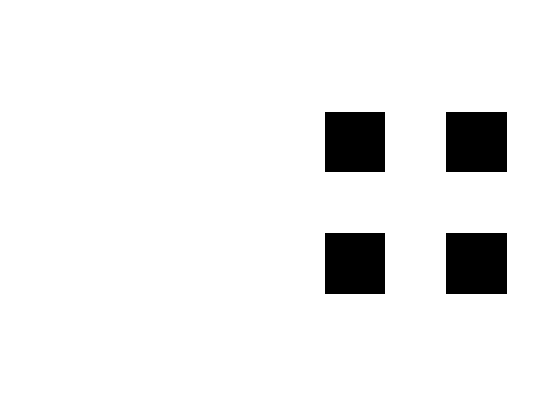

In [9]:
demo_size = 3
subplot(1,2,1); imshow(gen_struct(demo_size,5));
subplot(1,2,2); imshow(gen_struct(demo_size,6));

demo_size =  9


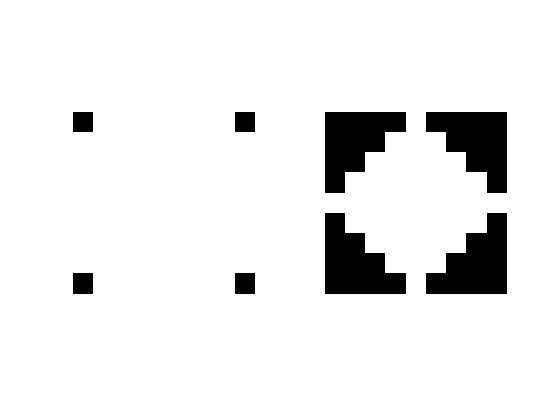

In [10]:
demo_size = 9
subplot(1,2,1); imshow(gen_struct(demo_size,5));
subplot(1,2,2); imshow(gen_struct(demo_size,6));

demo_size =  17


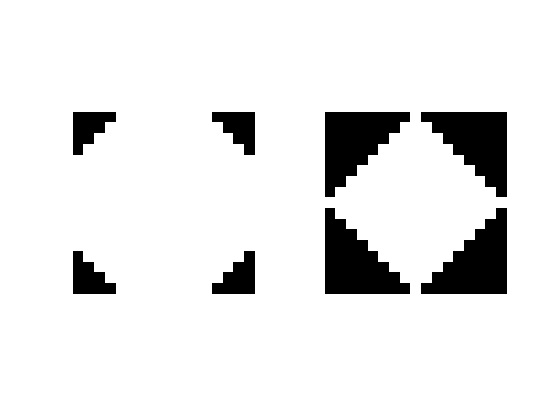

In [11]:
demo_size = 17
subplot(1,2,1); imshow(gen_struct(demo_size,5));
subplot(1,2,2); imshow(gen_struct(demo_size,6));

demo_size =  21


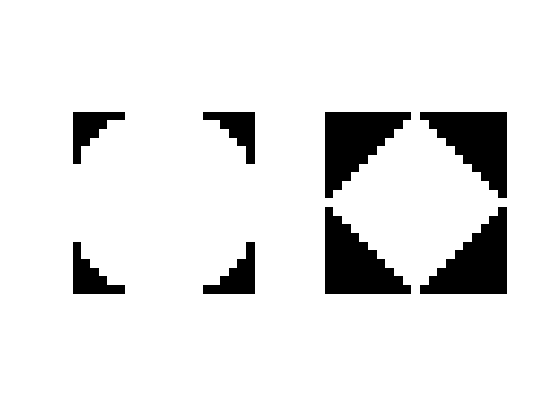

In [12]:
demo_size = 21
subplot(1,2,1); imshow(gen_struct(demo_size,5));
subplot(1,2,2); imshow(gen_struct(demo_size,6));

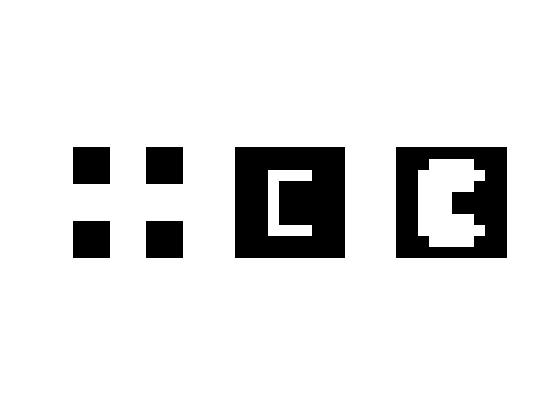

In [10]:
debug_DIL_STRUC = [0 1 0; 1 1 1; 0 1 0];
subplot(1,3,1); imshow(debug_DIL_STRUC);

debug_DIL = zeros(10,10);
debug_DIL(3,4:7) = 1;
debug_DIL(3:8,4) = 1;
debug_DIL(8,4:7) = 1;

subplot(1,3,2); imshow(debug_DIL);

debug_DIL = padding(debug_DIL, 2, size(debug_DIL_STRUC));
debug_DIL_RE = morphologic_converter(debug_DIL, 1, debug_DIL_STRUC, false);
subplot(1,3,3); imshow(debug_DIL_RE);

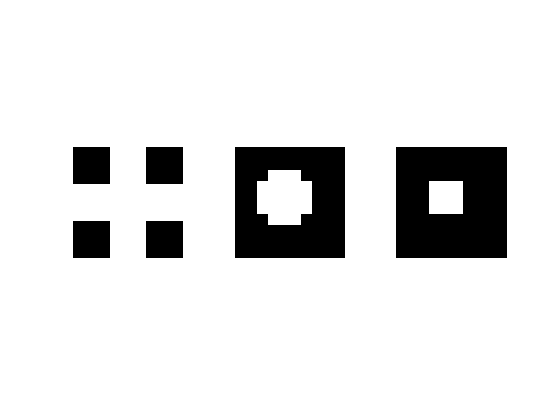

In [11]:
debug_ERO_STRUC = [0 1 0; 1 1 1; 0 1 0];
subplot(1,3,1); imshow(debug_ERO_STRUC);

debug_ERO = zeros(10,10);
debug_ERO(3,4:6) = 1;
debug_ERO(4:6,3:7) = 1;
debug_ERO(7,4:6) = 1;

subplot(1,3,2); imshow(debug_ERO);

debug_ERO = padding(debug_ERO, 2, size(debug_ERO_STRUC));
debug_ERO_RE = morphologic_converter(debug_ERO, 2, debug_ERO_STRUC, false);
subplot(1,3,3); imshow(debug_ERO_RE);

In [17]:
img =imread("../images/coins.png");
size(img)

error: imread: unable to find file '../images/coins.png'
error: called from
    imageIO at line 73 column 5
    imread at line 106 column 33
error: 'img' undefined near line 1 column 6


In [14]:
struct = gen_struct(35, 4);

In [15]:
pre_img = padding(img, 1, size(struct));
size(pre_img)
imshow(pre_img)

error: 'img' undefined near line 1 column 19
error: 'pre_img' undefined near line 1 column 6
error: 'pre_img' undefined near line 1 column 8


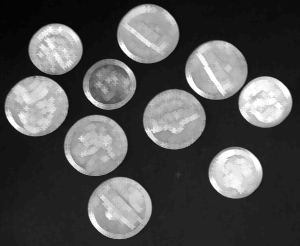

In [15]:
morph_matrix  = morphologic_converter(pre_img, 1, struct, true);
imshow(morph_matrix)

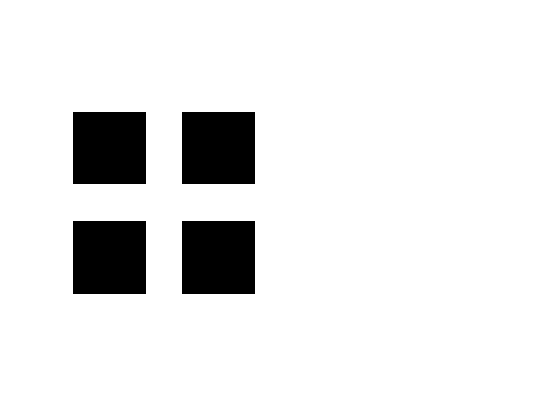

In [16]:
subplot(1,2,1); imshow(uint8(struct * 255));
subplot(1,2,2); imshow(morph_matrix);

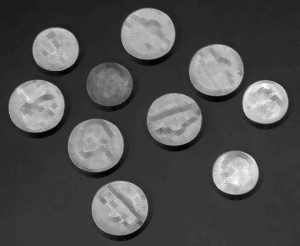

In [17]:
morph_matrix  = morphologic_converter(pre_img, 2, struct, true);
imshow(morph_matrix)

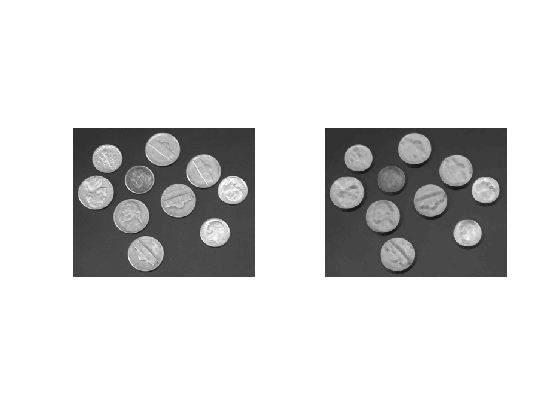

In [18]:
subplot(1,2,1); imshow(pre_img);
subplot(1,2,2); imshow(uint8(morph_matrix));

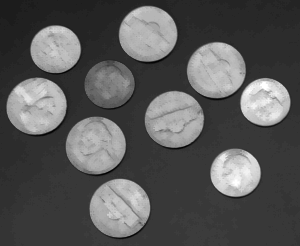

In [19]:
morph_matrix  = advance_morphologic_converter(pre_img, 1, struct, true);
imshow(morph_matrix)

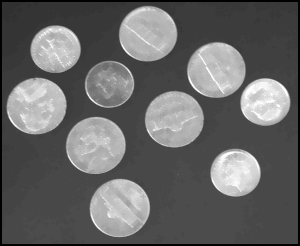

In [20]:
morph_matrix  = advance_morphologic_converter(pre_img, 2, struct, true);
imshow(morph_matrix)

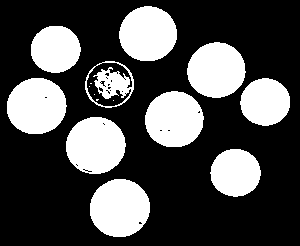

In [21]:
img_bw = im2bw(img,graythresh(img));
imshow(img_bw);

In [22]:
pre_img_bw = padding(img_bw, 1, size(struct));

In [23]:
struct = gen_struct(5,6)

struct =

  0  0  1  0  0
  0  1  1  1  0
  1  1  1  1  1
  0  1  1  1  0
  0  0  1  0  0



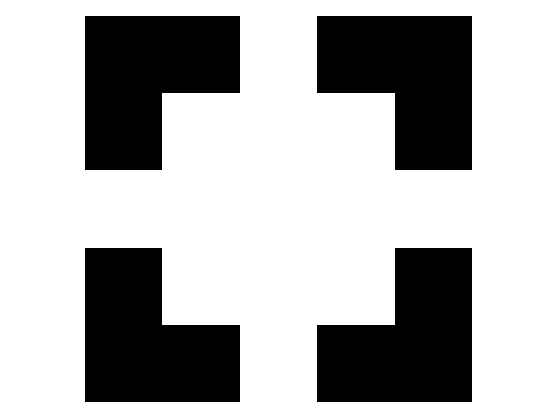

In [24]:
imshow(struct)

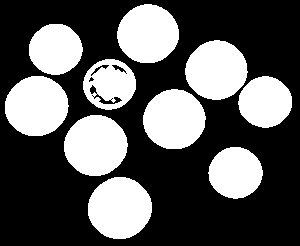

In [25]:
morph_matrix  = morphologic_converter(pre_img_bw, 1, struct, false);
imshow(morph_matrix)

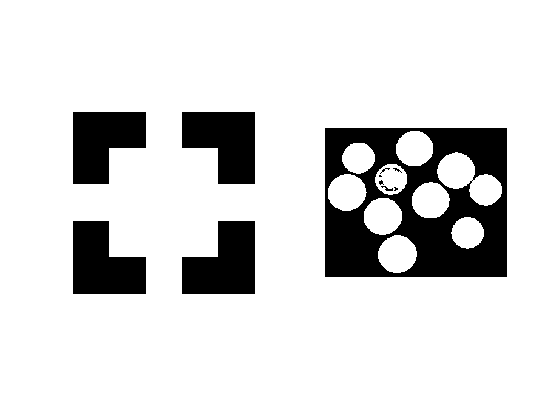

In [26]:
subplot(1,2,1); imshow(struct);
subplot(1,2,2); imshow(morph_matrix);

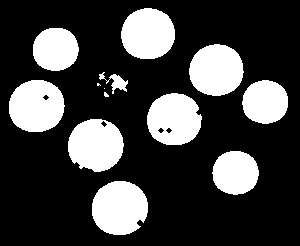

In [27]:
morph_matrix  = morphologic_converter(pre_img_bw, 2, struct, false);
imshow(morph_matrix)

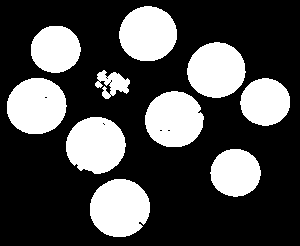

In [28]:
morph_matrix  = advance_morphologic_converter(pre_img_bw, 1, struct, false);
imshow(morph_matrix)

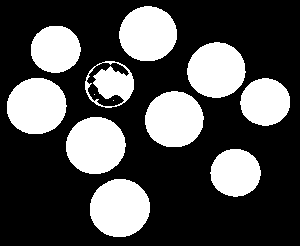

In [29]:
morph_matrix  = advance_morphologic_converter(pre_img_bw, 2, struct, false);
imshow(morph_matrix)

# DEMO - BW

In [ ]:
thisGray = false;

structNames = {"linea vertical", "linea horizontal", "cuadrado", "cruz", "circulo", "diamante"};
files = {"coins.png", "rice.png", "platesp.png", "cells.png", "text2.png"};
BASE_PATH = "../images/";
amount_files = size(files')(1);

fig_id = 1;
for n_ref = 3:2:9
    for i=1:amount_files
        current_path = strcat(BASE_PATH, files{i});
        current_img = imread(current_path);
        
        if size(size(current_img))(2) > 2
            current_img = uint8(rgb2gray(current_img));
        end
        
        og_img = current_img;
                
        if ~thisGray
            current_img = im2bw(current_img, graythresh(current_img));
        end
        
        for structType = 1:6
            currentStruct = gen_struct(n_ref, structType);
                        
            pre_img = padding(current_img, 2, size(currentStruct));
                      
            dilat_current = morphologic_converter(pre_img, 1, currentStruct, thisGray);
            
            eros_current = morphologic_converter(pre_img, 2, currentStruct, thisGray);
            
            apert_current = advance_morphologic_converter(pre_img, 1, currentStruct, thisGray);
            
            claus_current = advance_morphologic_converter(pre_img, 2, currentStruct, thisGray);
            
            %%%
            
            if thisGray
                dilat_current = uint8(dilat_current);
                eros_current = uint8(eros_current);
                apert_current = uint8(apert_current);
                claus_current = uint8(claus_current);
            end
            
            %%%
            
            figure;
            subplot(3,3,1); imshow(ones(3)); title(int2str(n_ref));
            if thisGray
                subplot(3,3,2); imshow(current_img); title(files{i});
            else
                subplot(3,3,2); imshow(og_img); title(files{i});
                subplot(3,3,3); imshow(current_img); title("Binarizacion");
            end
            
            subplot(3,3,4); imshow(currentStruct); title(structNames{structType});
            
            subplot(3,3,5); imshow(dilat_current); title("Dilatacion");
            subplot(3,3,6); imshow(eros_current); title("Erosion");
            subplot(3,3,7); imshow(apert_current); title("Apertura");
            subplot(3,3,8); imshow(claus_current); title("Clausura");
            
            filename = "./results/";
            if ~thisGray
                graySTR = "BW";
            else
                graySTR = "GR";
            end
            
            vars_str = {graySTR, int2str(n_ref), structNames{structType}, files{i}};
            filename = strcat(filename, strjoin(vars_str, "_"));
            disp(filename);
            saveas(fig_id , filename, "png");
            fig_id = fig_id + 1;
        end
    end
end

# DEMO - GRAY

In [ ]:
thisGray = true;

structNames = {"linea vertical", "linea horizontal", "cuadrado", "cruz", "circulo", "diamante"};
files = {"coins.png", "rice.png", "platesp.png", "cells.png", "text2.png"};
BASE_PATH = "../images/";
amount_files = size(files')(1);

fig_id = 1;
for n_ref = 3:2:9
    for i=1:amount_files
        current_path = strcat(BASE_PATH, files{i});
        current_img = imread(current_path);
        
        if size(size(current_img))(2) > 2
            current_img = uint8(rgb2gray(current_img));
        end
        
        og_img = current_img;
                
        if ~thisGray
            current_img = im2bw(current_img, graythresh(current_img));
        end
        
        for structType = 1:6
            currentStruct = gen_struct(n_ref, structType);
                        
            pre_img = padding(current_img, 2, size(currentStruct));
                      
            dilat_current = morphologic_converter(pre_img, 1, currentStruct, thisGray);
            
            eros_current = morphologic_converter(pre_img, 2, currentStruct, thisGray);
            
            apert_current = advance_morphologic_converter(pre_img, 1, currentStruct, thisGray);
            
            claus_current = advance_morphologic_converter(pre_img, 2, currentStruct, thisGray);
            
            %%%
            
            if thisGray
                dilat_current = uint8(dilat_current);
                eros_current = uint8(eros_current);
                apert_current = uint8(apert_current);
                claus_current = uint8(claus_current);
            end
            
            %%%
            
            figure;
            subplot(3,3,1); imshow(ones(3)); title(int2str(n_ref));
            if thisGray
                subplot(3,3,2); imshow(current_img); title(files{i});
            else
                subplot(3,3,2); imshow(og_img); title(files{i});
                subplot(3,3,3); imshow(current_img); title("Binarizacion");
            end
            
            subplot(3,3,4); imshow(currentStruct); title(structNames{structType});
            
            subplot(3,3,5); imshow(dilat_current); title("Dilatacion");
            subplot(3,3,6); imshow(eros_current); title("Erosion");
            subplot(3,3,7); imshow(apert_current); title("Apertura");
            subplot(3,3,8); imshow(claus_current); title("Clausura");
            
            filename = "./results/";
            if ~thisGray
                graySTR = "BW";
            else
                graySTR = "GR";
            end
            
            vars_str = {graySTR, int2str(n_ref), structNames{structType}, files{i}};
            filename = strcat(filename, strjoin(vars_str, "_"));
            disp(filename);
            saveas(fig_id , filename, "png");
            fig_id = fig_id + 1;
        end
    end
end